## ASTR 597A Homework 5
Eric Bellm

Due Feb 7, 2023

Your name: David
    
Your collaborators: Andy

In this homework we will attempt to "replicate" a classic SDSS paper ([Baldry et al. 2004](https://ui.adsabs.harvard.edu/abs/2004ApJ...600..681B/abstract)) with simulated Rubin data. Plotting the absolute r-band magnitudes of low-redshift galaxies vs. their (u-r) colors shows clearly the red sequence, blue clump, and green valley populations.  We will investigate if the DP0.2 galaxies show the same distribution, explore the implications since we won't have (many) spectroscopic redshifts, and look at possible evolution with redshift...

Portions of this work were developed based on [this notebook](https://github.com/rubin-dp0/delegate-contributions-dp02/tree/main/photoz/CMNN_Estimator) by Melissa Graham.

We will need to deal with "k-corrections" in order to convert our observer frame photometry to the rest frame.  See [Hogg et al. 2002](https://ui.adsabs.harvard.edu/abs/2002astro.ph.10394H/abstract) for a pedagogical overview.

The python package `kcorrect` by Mike Blanton provides our easist way to deal with this.  The package documentation is [here](https://kcorrect.readthedocs.io/), the source code [here](https://github.com/blanton144/kcorrect), and the paper describing the algorithm is [here](https://ui.adsabs.harvard.edu/abs/2007AJ....133..734B/abstract).

In [1]:
# As of Jan. 29, 2023, pypi version throws an error: install from github directly
!pip install --user git+https://github.com/blanton144/kcorrect.git

  Cloning https://github.com/blanton144/kcorrect.git to /tmp/pip-req-build-91y0xdue
  Running command git clone --filter=blob:none --quiet https://github.com/blanton144/kcorrect.git /tmp/pip-req-build-91y0xdue
  Resolved https://github.com/blanton144/kcorrect.git to commit 5e62bfc85eacb0aa5ab8a4b387d1283f528a337a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.8/798.8 kB 11.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for kcorrect: filename=kcorrect-5.0.0b0-py3-none-any.whl size=7788910 sha256=938c172c7044ed057d31ff018d55726a58af3ffdec27c7568056d482ec703a35
  Stored in directory: /tmp/pip-ephem-wheel-cache-3fam7qoz/wheels/3e/b2/2b/7a331a20a608056c6181648b7a11db0736f948c1c6d506d250
  Created wheel for pydl: filename=pydl-0.7.0-py3-none-any.whl size=572125 sha256=ce1db391c85158306b419a750585585b2eff41cb43c8649628082814bf890ed9
  Stored in directory: /home/ykwang1/.cache/pip/wheels/d3/75/d6/f605625b0f8baee9e

## Exercise 1: Low-redshift galaxy CMD with LSST

Plot the absolute r magnitude vs. rest-frame u-r color for 50,000 galaxies with z < 0.08.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.ma as ma

In [2]:
from lsst.rsp import get_tap_service, retrieve_query
service = get_tap_service()

Since we're going to need more columns than you might expect in this homework and the query is slow (~20 minutes), I'm going to provide the SQL query:

In [ ]:
query = "SELECT mt.id_truth_type AS mt_id_truth_type, "\
        "mt.match_objectId AS mt_match_objectId, "\
        "ts.truth_type AS ts_truth_type, "\
        "ts.redshift AS ts_redshift, "\
        "scisql_nanojanskyToAbMag(ts.flux_u) AS ts_mag_u, "\
        "scisql_nanojanskyToAbMag(ts.flux_g) AS ts_mag_g, "\
        "scisql_nanojanskyToAbMag(ts.flux_r) AS ts_mag_r, "\
        "scisql_nanojanskyToAbMag(ts.flux_i) AS ts_mag_i, "\
        "scisql_nanojanskyToAbMag(ts.flux_z) AS ts_mag_z, "\
        "scisql_nanojanskyToAbMag(ts.flux_y) AS ts_mag_y, "\
        "scisql_nanojanskyToAbMag(obj.u_cModelFlux) AS obj_cModelMag_u, "\
        "scisql_nanojanskyToAbMag(obj.g_cModelFlux) AS obj_cModelMag_g, "\
        "scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_cModelMag_r, "\
        "scisql_nanojanskyToAbMag(obj.i_cModelFlux) AS obj_cModelMag_i, "\
        "scisql_nanojanskyToAbMag(obj.z_cModelFlux) AS obj_cModelMag_z, "\
        "scisql_nanojanskyToAbMag(obj.y_cModelFlux) AS obj_cModelMag_y, "\
        "scisql_nanojanskyToAbMagSigma(obj.u_cModelFlux,obj.u_cModelFluxErr) AS obj_cModelMagErr_u, "\
        "scisql_nanojanskyToAbMagSigma(obj.g_cModelFlux,obj.g_cModelFluxErr) AS obj_cModelMagErr_g, "\
        "scisql_nanojanskyToAbMagSigma(obj.r_cModelFlux,obj.r_cModelFluxErr) AS obj_cModelMagErr_r, "\
        "scisql_nanojanskyToAbMagSigma(obj.i_cModelFlux,obj.i_cModelFluxErr) AS obj_cModelMagErr_i, "\
        "scisql_nanojanskyToAbMagSigma(obj.z_cModelFlux,obj.z_cModelFluxErr) AS obj_cModelMagErr_z, "\
        "scisql_nanojanskyToAbMagSigma(obj.y_cModelFlux,obj.y_cModelFluxErr) AS obj_cModelMagErr_y "\
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId "\
        "WHERE ts.truth_type = 1 "\ 
        "AND ts.redshift < 0.08 "\
        "LIMIT 50000"
print(query)

In [ ]:
%%time
job = service.submit_job(query)
print('Job URL is', job.url)
print('Job phase is', job.phase)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

In [ ]:
#job.raise_if_error()

In [ ]:
df = job.fetch_result().to_table().to_pandas()

In [ ]:
# since the query is slow let's save the results
df.to_parquet('lowz_query_results.parquet')

In [3]:
# reread from file if needed
df = pd.read_parquet('../data/lowz_query_results.parquet')

In [4]:
df

,mt_id_truth_type,mt_match_objectId,ts_truth_type,ts_redshift,ts_mag_u,ts_mag_g,ts_mag_r,ts_mag_i,ts_mag_z,ts_mag_y,...,obj_cModelMag_r,obj_cModelMag_i,obj_cModelMag_z,obj_cModelMag_y,obj_cModelMagErr_u,obj_cModelMagErr_g,obj_cModelMagErr_r,obj_cModelMagErr_i,obj_cModelMagErr_z,obj_cModelMagErr_y
0,11625000927_1,1248640588874550129,1,0.068545,25.368659,23.993546,23.277992,22.934948,22.751299,22.649465,...,23.329978,22.932269,22.888358,22.817439,0.208253,0.028675,0.017220,0.020798,0.058900,0.096465
1,11625000244_1,1248640588874517109,1,0.048841,24.654123,23.606055,23.314360,23.152942,23.092924,23.052208,...,23.217496,23.124112,22.991623,22.842392,0.166401,0.023759,0.022805,0.034589,0.077102,0.124587
2,10937503555_1,1248640588874517199,1,0.075362,25.916402,24.780301,24.478011,24.333722,24.267291,24.229427,...,24.527734,24.299451,24.177062,24.232373,0.217547,0.047683,0.047646,0.080916,0.167949,0.408887
3,11625001671_1,1248640588874516737,1,0.056030,25.127269,23.890629,23.309914,23.028135,22.891138,22.810152,...,23.361802,23.120256,22.907939,22.960508,0.221223,0.025247,0.020279,0.026663,0.058832,0.114017
4,11625000562_1,1248640588874519788,1,0.047383,25.268361,24.108642,23.635673,23.407956,23.332769,23.277724,...,23.648322,23.497239,23.135417,23.284508,0.253983,0.031621,0.026171,0.036686,0.089457,0.146765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,9875000912_1,1407946629599754676,1,0.060529,23.307827,22.062964,21.621300,21.412971,21.337813,21.285201,...,21.564044,21.405161,21.304477,21.260882,0.054119,0.005850,0.004957,0.007061,0.017032,0.028273
49996,9875002461_1,1407946629599753787,1,0.077536,26.520665,25.275861,24.738236,24.491204,24.377313,24.318601,...,24.647846,24.469864,24.193127,25.253000,0.657467,0.049986,0.040618,0.060306,0.126354,0.668700
49997,9875001793_1,1407946629599727957,1,0.067203,23.769015,22.197932,21.388387,20.955008,20.626272,20.437266,...,21.444892,21.003300,20.699195,20.541354,0.052691,0.005081,0.002906,0.003400,0.006410,0.011485
49998,9875001755_1,1407990610064835017,1,0.070171,25.358664,24.122235,23.697634,23.484757,23.378225,23.330555,...,23.608735,23.466844,23.410089,23.264469,0.164028,0.020748,0.015574,0.023708,0.062466,0.119411


We now have the true redshifts and both true and "observed" magnitudes in all bands for sources we know are galaxies (`ts.truth_type == 1`; this is a bit of a cheat!).  To get the absolute magnitude we need the distance modulus and the k-correction (see the references above, or [here](https://kcorrect.readthedocs.io/en/5.0.0b/basics.html#) for a briefer overview).  (The rest-frame color requires the k-corrections as well.)  To use `kcorrect` we need to make some unit conversions.

`kcorrect` doesn't have LSST bands in it.  So we will approximate with SDSS ugriz.

In [5]:
import kcorrect.kcorrect

responses = ['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0']
kc = kcorrect.kcorrect.Kcorrect(responses=responses)

`kcorrect` wants inputs in units of maggies and their inverse variances, as numpy arrays with dimensions (objects x filters).  For convenience here is that conversion:

In [6]:
df.dropna(subset=['ts_redshift', 'obj_cModelMag_u', 'obj_cModelMag_g', 'obj_cModelMag_r',
       'obj_cModelMag_i', 'obj_cModelMag_z', 'obj_cModelMagErr_u', 'obj_cModelMagErr_g', 
        'obj_cModelMagErr_r', 'obj_cModelMagErr_i', 'obj_cModelMagErr_z'], inplace=True)

In [7]:
maggies = df[['obj_cModelMag_u', 'obj_cModelMag_g', 'obj_cModelMag_r',
       'obj_cModelMag_i', 'obj_cModelMag_z']].apply(
    lambda x: 10.0 ** (-0.4 * x)).values
maggies

array([[  8.35448675e-11,   2.45075093e-10,   4.65595429e-10,
          6.71571760e-10,   6.99289323e-10],
       [  1.57362575e-10,   3.98974628e-10,   5.16418448e-10,
          5.62801502e-10,   6.35844598e-10],
       [  8.39382799e-11,   1.23437652e-10,   1.54492107e-10,
          1.90642463e-10,   2.13390618e-10],
       ..., 
       [  2.86061293e-10,   1.28544409e-09,   2.64267117e-09,
          3.96898859e-09,   5.25196680e-09],
       [  7.67642123e-11,   2.39516333e-10,   3.60168862e-10,
          4.10452107e-10,   4.32478460e-10],
       [  2.64084641e-10,   1.04129494e-09,   1.66060389e-09,
          2.10059090e-09,   2.24564503e-09]])

In [8]:
ivars = df[['obj_cModelMagErr_u', 'obj_cModelMagErr_g', 'obj_cModelMagErr_r',
       'obj_cModelMagErr_i', 'obj_cModelMagErr_z']].apply(
    lambda x: 1./ (0.4 * np.log(10) * x) ** 2.).values / (maggies**2.)
ivars

array([[  3.89428901e+21,   2.38697306e+22,   1.83375435e+22,
          6.04234740e+21,   6.94882815e+20],
       [  1.71923432e+21,   1.31193964e+22,   8.49916547e+21,
          3.11079803e+21,   4.90468146e+20],
       [  3.53526179e+21,   3.40270911e+22,   2.17558543e+22,
          4.95381460e+21,   9.17794433e+20],
       ..., 
       [  5.18878496e+21,   2.76292233e+22,   1.99948278e+22,
          6.47209290e+21,   1.04019536e+21],
       [  7.43522611e+21,   4.77316615e+22,   3.74676118e+22,
          1.24489878e+22,   1.61521420e+21],
       [  2.46633341e+21,   1.43626129e+22,   1.06012352e+22,
          2.85085892e+21,   4.57835620e+20]])

Now use `kcorrect` to compute the rest-frame absolute magnitude in r-band as well as the rest frame u-r color, and plot them.  Note that you'll need to exclude some rows with `NaN`s.

Compare your result qualitatively to Figure 1 of Baldry et al. 2004.

#### calculate correction copying code from kcorrect example

In [9]:
redshift = df['ts_redshift']
coeffs = kc.fit_coeffs(redshift=redshift, maggies=maggies, ivar=ivars)

k = kc.kcorrect(redshift=redshift, coeffs=coeffs)
absmag = kc.absmag(redshift=redshift, maggies=maggies, ivar=ivars, coeffs=coeffs)



 NNLS quitting on iteration count.

 NNLS quitting on iteration count.


In [10]:
responses

['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0']

#### Select abs mags for u and r bands and plot $M_r$ vs $u-r$ like Baldry et al.

In [11]:
u_mags = absmag[:,0]
r_mags = absmag[:,2]

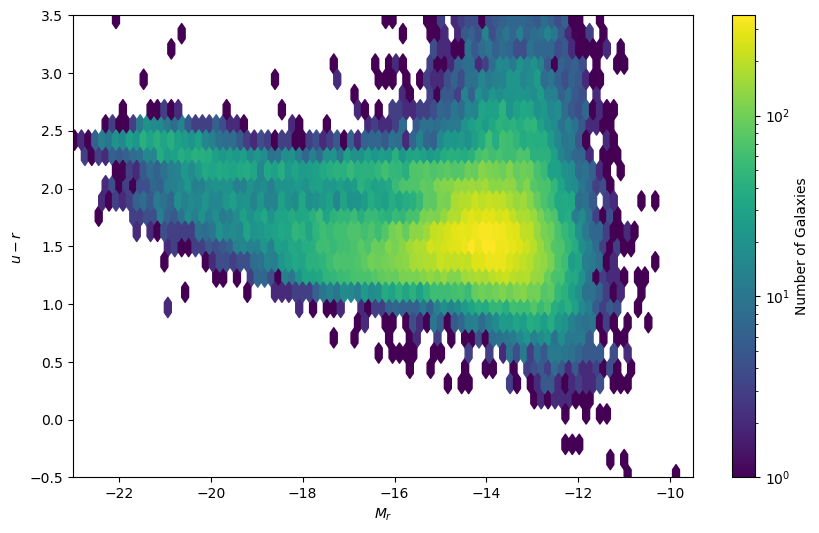

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

hexbin = ax.hexbin(r_mags, u_mags - r_mags, bins='log')
fig.colorbar(hexbin, label='Number of Galaxies')

ax.set_xlim([-9.5, -23])
ax.set_ylim([-.5, 3.5])

ax.set_xlabel('$M_r$')
ax.set_ylabel('$u - r$')

ax.invert_xaxis()
plt.show()

Original plot shown below. We can see that we have many more faint galaxies ($M_r$ between -16 and -14). Note that in our plot, we also include galaxies at $z \lt 0.04$ although this is only a small percentage of the sample--the main difference is that the simulated LSST data goes much deeper. However, we see that a green valley is still somewhat present at $u-r$ around 2, at least for galaxies with $M_r$ brighter than -16. The highest density of galaxies is at $M_r \approx -14$ and $u-r \approx 1.5$ instead of at $M_r \approx -21$ and $u-r \approx 2.5$

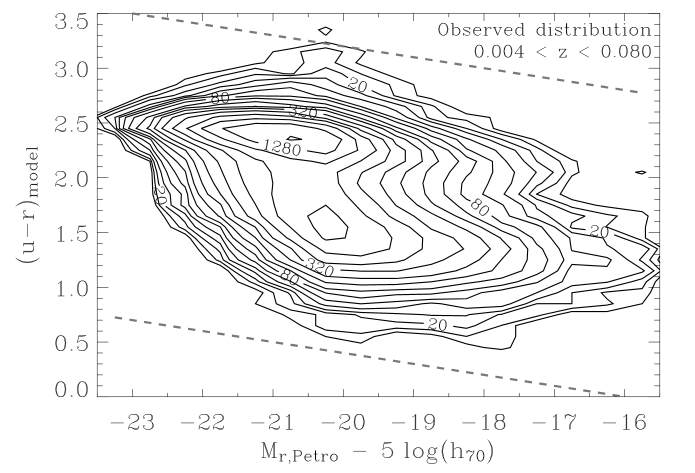

<AxesSubplot:>

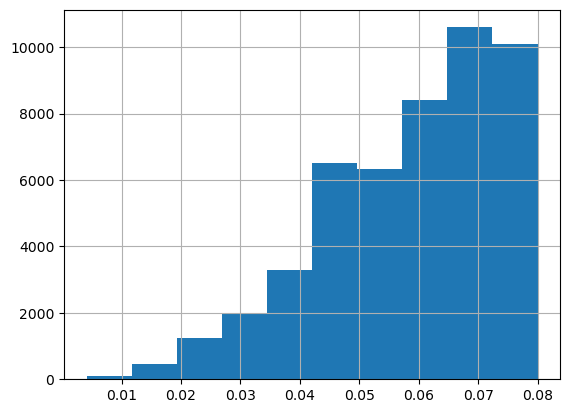

In [20]:
redshift.hist()

Note that if we plot only galaxies with apparent mag brighter than 19, the distribution looks closer to that in Baldry et al.

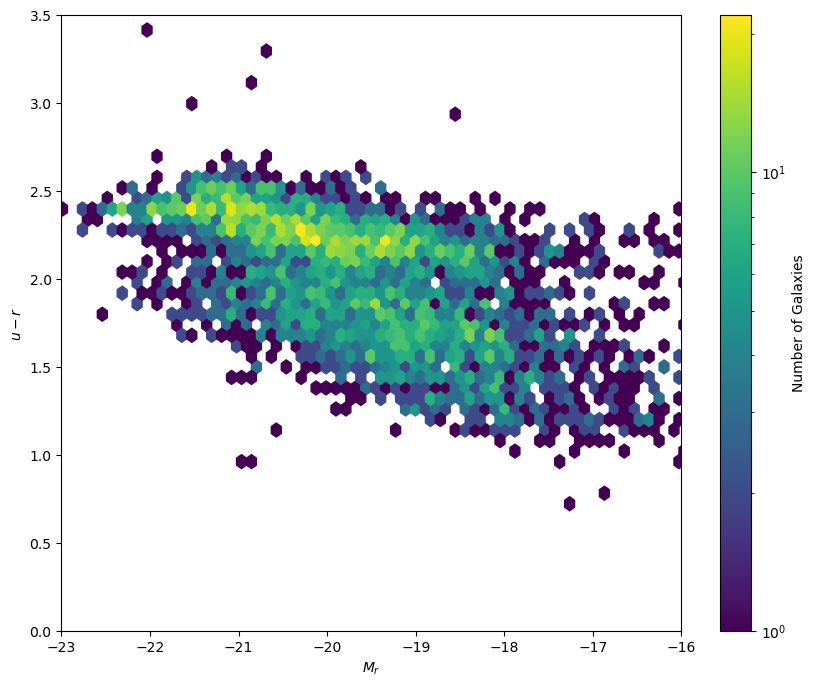

In [13]:
mask = df['ts_mag_r'].values < 19
# ((.04 < df['ts_redshift']) & (df['ts_redshift'] < .08))

fig, ax = plt.subplots(figsize=(10, 8))

hexbin = ax.hexbin(r_mags[mask], u_mags[mask] - r_mags[mask], bins='log')
fig.colorbar(hexbin, label='Number of Galaxies')

ax.set_xlim([-16, -23])
ax.set_ylim([0, 3.5])

ax.set_xlabel('$M_r$')
ax.set_ylabel('$u - r$')

ax.invert_xaxis()
plt.show()

## Exercise 2: Removing a cheat

We made two cheats above: we used the truth table to tell us which galaxies we have as well as their redshifts.  In SDSS those redshifts were obtained through spectroscopy, but for Rubin most redshifts will have to be obtained photometrically.

Using the data from our query above, follow [this notebook](https://github.com/rubin-dp0/delegate-contributions-dp02/tree/main/photoz/CMNN_Estimator) by Melissa Graham to compute a very simple photo-z for these galaxies.  Plot the true redshift vs estimated photo-z, and then re-plot the CMD from Exercise 1 using photo-z rather than the true spectroscopic redshift.

In [14]:
from scipy.stats import chi2
import datetime


In [15]:
results = df.copy() #pd.read_parquet('../data/lowz_query_results.parquet')

#### copy code from Melissa's notebook

In [16]:
data_id = np.asarray(results['mt_match_objectId'], dtype='int')

# true ("spec") redshifts
data_tz = np.asarray(results['ts_redshift'], dtype='float')

# true ("spec") magnitudes
data_tm = np.transpose(np.asarray((results['ts_mag_u'],results['ts_mag_g'],\
                                   results['ts_mag_r'],results['ts_mag_i'],\
                                   results['ts_mag_z'],results['ts_mag_y']),\
                                  dtype='float' ) )

# object apparent magnitudes
data_om = np.transpose(np.asarray((results['obj_cModelMag_u'],results['obj_cModelMag_g'],\
                                   results['obj_cModelMag_r'],results['obj_cModelMag_i'],\
                                   results['obj_cModelMag_z'],results['obj_cModelMag_y']),\
                                  dtype='float' ) )

# object apparent magnitude errors
data_ome = np.transpose(np.asarray((results['obj_cModelMagErr_u'],results['obj_cModelMagErr_g'],\
                                    results['obj_cModelMagErr_r'],results['obj_cModelMagErr_i'],\
                                    results['obj_cModelMagErr_z'],results['obj_cModelMagErr_y']),\
                                   dtype='float' ) )

# true ("spec") and object colors and color errors
data_tc = np.zeros( (len(data_om),5), dtype='float' )
data_oc = np.zeros( (len(data_om),5), dtype='float' )
data_oce = np.zeros( (len(data_om),5), dtype='float' )

data_tc[:,0] = data_tm[:,0] - data_tm[:,1]
data_tc[:,1] = data_tm[:,1] - data_tm[:,2]
data_tc[:,2] = data_tm[:,2] - data_tm[:,3]
data_tc[:,3] = data_tm[:,3] - data_tm[:,4]
data_tc[:,4] = data_tm[:,4] - data_tm[:,5]

data_oc[:,0] = data_om[:,0] - data_om[:,1]
data_oc[:,1] = data_om[:,1] - data_om[:,2]
data_oc[:,2] = data_om[:,2] - data_om[:,3]
data_oc[:,3] = data_om[:,3] - data_om[:,4]
data_oc[:,4] = data_om[:,4] - data_om[:,5]

data_oce[:,0] = np.sqrt( data_ome[:,0]**2 + data_ome[:,1]**2 )
data_oce[:,1] = np.sqrt( data_ome[:,1]**2 + data_ome[:,2]**2 )
data_oce[:,2] = np.sqrt( data_ome[:,2]**2 + data_ome[:,3]**2 )
data_oce[:,3] = np.sqrt( data_ome[:,3]**2 + data_ome[:,4]**2 )
data_oce[:,4] = np.sqrt( data_ome[:,4]**2 + data_ome[:,5]**2 )

In [17]:
cmnn_ppf = 0.68 
cmnn_minNclr = 5

cmnn_thresh_table = np.zeros(6, dtype='float')
for d in range(6):
    cmnn_thresh_table[d] = chi2.ppf(cmnn_ppf,d)
cmnn_thresh_table[0] = float(0.0000)

for d in range(6):
    print('degrees of freedom = %1i, threshold = %5.3f' % (d, np.round(cmnn_thresh_table[d],3)))

data_pz = np.zeros(len(data_tz), dtype='float') - 1.0
data_pze = np.zeros(len(data_tz), dtype='float') - 1.0

# use all ~50000 data points
# Ncalc = 5000
Ncalc = len(data_tz)
rx = np.random.choice(len(data_tz), Ncalc, replace=False)

degrees of freedom = 0, threshold = 0.000
degrees of freedom = 1, threshold = 0.989
degrees of freedom = 2, threshold = 2.279
degrees of freedom = 3, threshold = 3.506
degrees of freedom = 4, threshold = 4.695
degrees of freedom = 5, threshold = 5.861


In [ ]:
%%time

t1 = datetime.datetime.now()

for i,r in enumerate(rx):
    if (i == 100) | ((i%1000) == 1) | (i == Ncalc-1000):
        t2 = datetime.datetime.now()
        telapsed = t2-t1
        print(i, t2-t1, ((telapsed)/float(i))*(float(Ncalc)) - telapsed, ' remaining' )

    # calculate DM and DOF
    DM  = np.nansum((data_oc[r,:] - data_tc[:,:])**2 / data_oce[r,:]**2, axis=1, dtype='float')
    DOF = np.nansum((data_oc[r,:]**2 + data_tc[:,:]**2 + 1.0) / (data_oc[r,:]**2 + data_tc[:,:]**2 + 1.0), axis=1, dtype='int')
    
    # calculate the thresholds
    data_th = np.zeros(len(DOF), dtype='float')
    for d in range(6):
        tx = np.where(DOF == d)[0]
        data_th[tx] = cmnn_thresh_table[d]
        del tx
    
    DM[r] = 99.9

    # identify the CMNN subset of training-set galaxies:
    # those for which the DM is less than the threshold
    ix = np.where((DOF >= cmnn_minNclr) & (data_th > 0.00010) & \
                  (DM > 0.00010) & (DM <= data_th))[0]
    
    if len(ix) > 0:
        # choose a random training-set galaxy from the CMNN subset
        rix = np.random.choice(ix, size=1, replace=False)[0]
        data_pz[r] = data_tz[rix]
        data_pze[r] = np.std(data_tz[ix])
        del rix
    else:
        data_pz[r] = float('nan')
        data_pze[r] = float('nan')
        
    del DM, DOF, data_th, ix

1 0:00:00.008600 0:07:01.167800  remaining
100 0:00:00.571132 0:04:39.119382  remaining
1001 0:00:05.625739 0:04:29.608141  remaining
2001 0:00:11.189789 0:04:22.672819  remaining
3001 0:00:16.777801 0:04:17.035833  remaining
4001 0:00:22.345623 0:04:11.174167  remaining
5001 0:00:27.859844 0:04:04.974310  remaining
6001 0:00:33.388256 0:03:59.103080  remaining
7001 0:00:38.910767 0:03:53.286725  remaining
8001 0:00:44.497824 0:03:47.895564  remaining
9001 0:00:50.104133 0:03:42.534125  remaining
10001 0:00:55.688670 0:03:36.998562  remaining
11001 0:01:01.251059 0:03:31.436173  remaining
12001 0:01:06.749052 0:03:25.644336  remaining
13001 0:01:12.394198 0:03:20.293034  remaining
14001 0:01:17.930952 0:03:14.658332  remaining
15001 0:01:23.494943 0:03:09.094341  remaining
16001 0:01:29.024909 0:03:03.466427  remaining
17001 0:01:34.546299 0:02:57.798115  remaining
18001 0:01:40.090044 0:02:52.205396  remaining
19001 0:01:45.598594 0:02:46.598898  remaining
20001 0:01:51.059267 0:02:40

In [21]:
tx = np.where( np.isnan(data_pz) )[0]
print( len(tx), ' galaxies did not get a pz estimate' )
del tx

tx = np.where( data_pz > 0.0 )[0]
print( len(tx), ' galaxies did get a pz estimate' )
del tx

24714  galaxies did not get a pz estimate
24260  galaxies did get a pz estimate


In [23]:
pz_mask = ~np.isnan(data_pz)
pzs = data_pz[pz_mask]
zs = redshift[pz_mask]

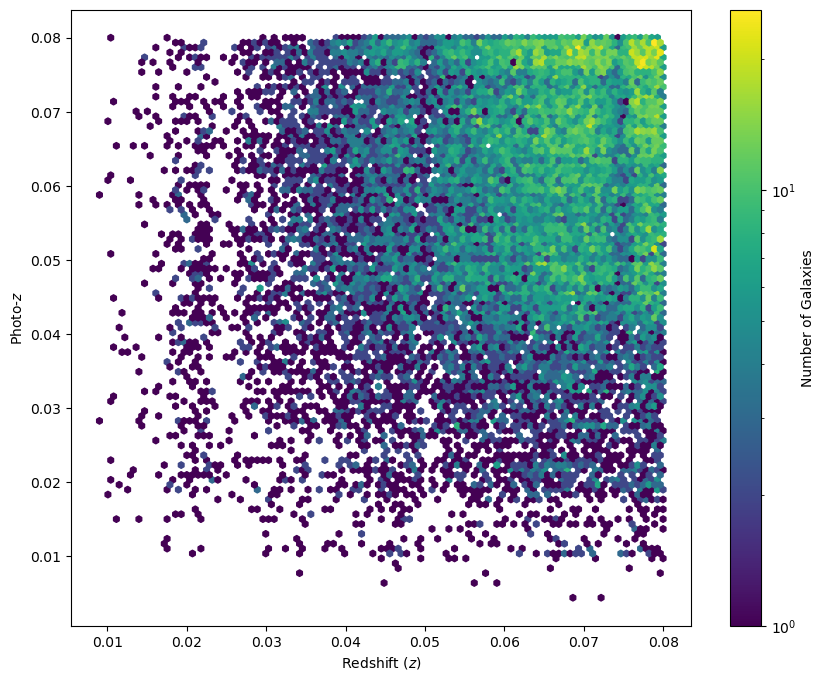

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))



hexbin = ax.hexbin(zs, pzs, bins='log')
fig.colorbar(hexbin, label='Number of Galaxies')

ax.set_xlabel('Redshift ($z$)')
ax.set_ylabel('Photo-$z$')

# ax.invert_xaxis()
plt.show()

Yikes, this approximation is pretty rough looking (at least on the scale here)

In [26]:
coeffs = kc.fit_coeffs(redshift=data_pz[pz_mask], maggies=maggies[pz_mask], ivar=ivars[pz_mask])

k = kc.kcorrect(redshift=data_pz[pz_mask], coeffs=coeffs)
absmag = kc.absmag(redshift=data_pz[pz_mask], maggies=maggies[pz_mask], ivar=ivars[pz_mask], coeffs=coeffs)

u_mags = absmag[:,0]
r_mags = absmag[:,2]


 NNLS quitting on iteration count.

 NNLS quitting on iteration count.


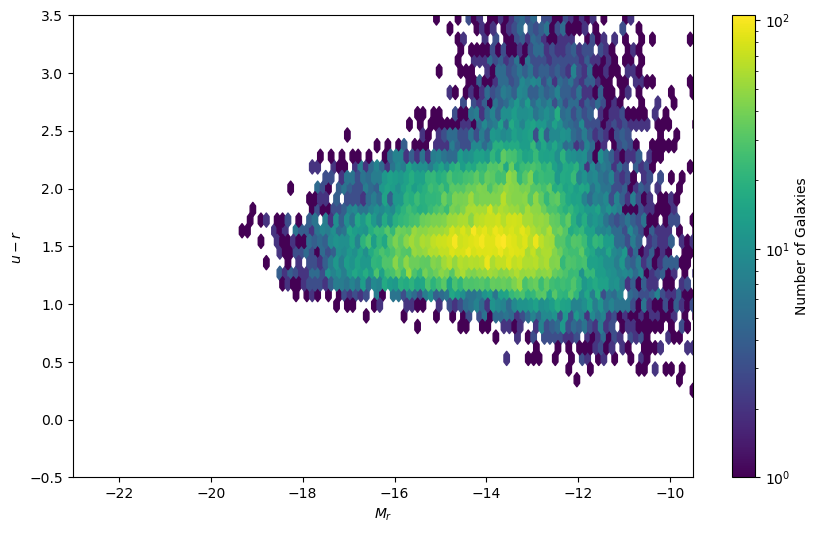

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

hexbin = ax.hexbin(r_mags, u_mags - r_mags, bins='log')
fig.colorbar(hexbin, label='Number of Galaxies')

ax.set_xlim([-9.5, -23])
ax.set_ylim([-.5, 3.5])

ax.set_xlabel('$M_r$')
ax.set_ylabel('$u - r$')

ax.invert_xaxis()
plt.show()

Much harder to draw conclusions based on this plot.

## Exercise 3 (Optional): Hi-Z

Repeat exercise 1 for a higher redshift range (z=1.5-2?) and see how the CMD changes.